# Facial Keypoint Detection Kaggle 

In [2]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

## Loading the data

In [3]:
FTRAIN = '/home/alirk/dataScience/kaggle/facialKeypointsDetection/project/Kaggle-facialKeypointsDetection-LearningSeminar/data/training.zip'
FTEST = '/home/alirk/dataScience/kaggle/facialKeypointsDetection/project/Kaggle-facialKeypointsDetection-LearningSeminar/data/test.zip'

In [4]:
def load (test=False, cols=None):
    fname = FTEST if test else FTRAIN
    df = read_csv (os.path.expanduser(fname)) # Load pandas dataframe
    
    
    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda  im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols) + ['Image']]
        
    print (df.count())
    
    df = df.dropna() # drop all rows that have missing values in the
    
    X = np.vstack(df['Image'].values) / 255 # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    
    if not test: # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y-48) / 48
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y


X, y = load()



print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## First Model: a single hidden layer

In [5]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet


/home/alirk/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
net1 = NeuralNet(
    # defining layers, three layers 
    layers=[
        ('input' , layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    
    input_shape = (None, 9216),  # 96*96 input pixels per batch
    hidden_num_units = 100, # number of units in hidden layer
    output_nonlinearity = None, # output  layer uses identity function
    
    
    output_num_units = 30,  # 30 target values
    
    
    # optimization method
    update = nesterov_momentum,
    update_learning_rate = 0.01,
    update_momentum = 0.9,
    
    
    regression = True, # a flag indicating we're dealing with regression problem
    max_epochs = 400, # we want to train this many epochs
    verbose=1,
    
    
    
    )


X, y = load()
net1.fit(X, y)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f754f54ea10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f754f54e910>,
     check_input=True, custom_scores=None, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7f754f553d70>,
     objective_loss_function=<function squared_error at 0x7f75501dd9b0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f7552a0f5a8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f7552a0f5f0>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     scores_train=[], scores_va

## ploting the learning curve

In [12]:
import matplotlib.pyplot as plt

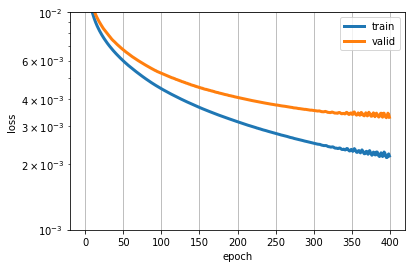

In [13]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])

plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")
plt.show()

as it's obvious we're dealing with overfitting problem here

Let's pick a few examples from the test set and check it $\dots$

ImageId    1783
Image      1783
dtype: int64


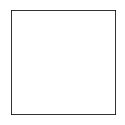

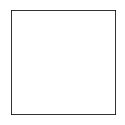

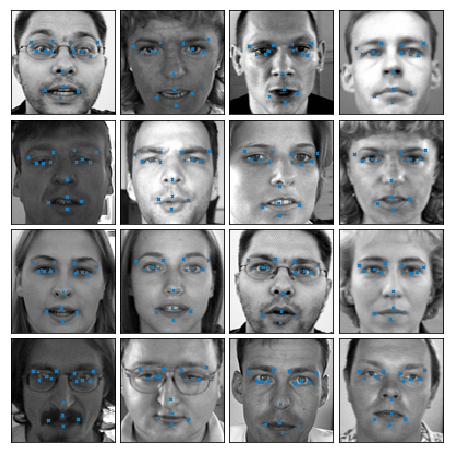

In [27]:
def plot_sample (x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _   = load(test=True)
y_pred = net1.predict(X)


fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)
    
plt.show()



## Second model: CNN

function load2d would wraps previously written *load* and does the necessary transformations 

In [28]:
def load2d (test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [ ]:
net2 = NeuralNet(
    
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    
    input_shape = (None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,
    
    
    update_learning_rate=0.01,
    update_momentum=0.9,
    
    regression=True,
    max_epochs=1000,
    verbose=1,
    
    )

X, y = load2d()
net2.fit(X, y)



import cPickle as pickle
with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b